### In this notebook, we show how simple it is to drop-in replace pandas and numpy with cudf and cupy to deliver up to 100x speedup for Gauss Rank transformation

In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")

from numba import jit 
import numpy as np
import pandas as pd

from sklearn.metrics import cohen_kappa_score, confusion_matrix
import cupy as cp
import cudf as gd

print('cudf',gd.__version__)
print('cupy',cp.__version__)

import time
import matplotlib.pyplot as plt
from cupyx.scipy.special import erfinv as cupy_erfinv
from scipy.special import erfinv
from pathlib import Path

import matplotlib.pyplot as plt

cudf 0.10.0
cupy 6.5.0


In [3]:
class GaussRank():
    """
    CPU & GPU codes are mostly the same except for the imported libraries.
    GPU codes are executed automatically if the input tensor is on GPU.
    """
    def __init__(self,epsilon=0.001):
        self.epsilon = epsilon
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower

    def fit(self,x):
        self.fit_transform(x)
        return self    
        
    def fit_transform(self,x):
        # x is a 1D numpy/cupy array
        msg = 'input must be a 1D numpy/cucpy array'
        
        assert isinstance(x,np.ndarray) or isinstance(x,cp.ndarray),msg
        erfinv_ = erfinv if isinstance(x,np.ndarray) else cupy_erfinv
        DataFrame = pd.DataFrame if isinstance(x,np.ndarray) else gd.DataFrame
        
        j = x.argsort().argsort()

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv_(transformed)
        
        transformed_map = DataFrame()
        transformed_map['src'] = x
        transformed_map['tgt'] = transformed
        transformed_map = transformed_map.sort_values(by='src',ascending=True)
        self.transformed_map = transformed_map
        return transformed
    
    def transform(self,x):
        return self._transform(x,src_col='src',tgt_col='tgt')
    
    def inverse_transform(self,transformed):
        return self._transform(transformed,src_col='tgt',tgt_col='src')
    
    def _transform(self,x,src_col,tgt_col):
        msg = 'input must be a 1D numpy/cucpy array'
        assert isinstance(x,np.ndarray) or isinstance(x,cp.ndarray),msg
        transformed_map = self.transformed_map
        N = len(transformed_map)
        pos = transformed_map[src_col].searchsorted(x, side='left')
        
        if isinstance(x,cp.ndarray): pos = pos.values
            
        pos[pos>=N] = N-1
        pos[pos-1<=0] = 0

        x1 = transformed_map[src_col].values[pos]
        x2 = transformed_map[src_col].values[pos-1]
        y1 = transformed_map[tgt_col].values[pos]
        y2 = transformed_map[tgt_col].values[pos-1]

        relative = (x-x2)  / (x1-x2)
        return (1-relative)*y2 + relative*y1

### Verify correctness

In [4]:
%%time
x = np.random.rand(10)
gau_cpu = GaussRank()
res_cpu_a = gau_cpu.fit_transform(x)
res_cpu_b = gau_cpu.transform(x)
print(res_cpu_a)
print(res_cpu_b)

x_gpu = cp.asarray(x)
gau_gpu = GaussRank()
res_gpu_a = gau_gpu.fit_transform(x_gpu)
res_gpu_b = gau_gpu.transform(x_gpu)
print(res_gpu_a)
print(res_gpu_b)
print()

print('check transformation results: mean absolute error between cpu and gpu')
print(np.abs(cp.asnumpy(res_gpu_a)-res_cpu_a).mean())
print(np.abs(cp.asnumpy(res_gpu_b)-res_cpu_b).mean())

[-0.3042461  -0.54007207 -0.86167297 -2.32675377  0.54007207  0.09869067
  2.32675377 -0.09869067  0.3042461   0.86167297]
[-0.3042461  -0.54007207 -2.2038276  -2.32675377  0.54007207  0.09869067
  2.32675377 -0.09869067  0.3042461   0.86167297]
[-0.3042461  -0.54007207 -0.86167297 -2.32675377  0.54007207  0.09869067
  2.32675377 -0.09869067  0.3042461   0.86167297]
[-0.3042461  -0.54007207 -2.2038276  -2.32675377  0.54007207  0.09869067
  2.32675377 -0.09869067  0.3042461   0.86167297]

check transformation results: mean absolute error between cpu and gpu
2.2912227670701667e-15
2.3578361485476763e-15
CPU times: user 452 ms, sys: 592 ms, total: 1.04 s
Wall time: 1.08 s


In [5]:
%%time
x_inv_cpu = gau_cpu.inverse_transform(res_cpu_b)
x_inv_gpu = gau_gpu.inverse_transform(res_gpu_b)
print('check inverse transformation results: mean absolute error between cpu and gpu')
print(np.abs(cp.asnumpy(x_inv_gpu)-x_inv_cpu).mean())

check inverse transformation results: mean absolute error between cpu and gpu
8.326672684688674e-18
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.21 ms


### Visualization with real world [data](https://www.kaggle.com/c/champs-scalar-coupling/data)

In [6]:
path = Path('/raid/data/ml/kaggle/champs/train.csv')
df = gd.read_csv(path)
df['type'].value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int32

In [7]:
mask = df['type'] == '3JHC'
x_gpu = df.loc[mask,'scalar_coupling_constant'].values
x_cpu = cp.asnumpy(x_gpu)

In [8]:
%%time
gau_cpu = GaussRank()
gau_cpu.fit_transform(x_cpu)
res_cpu = gau_cpu.transform(x_cpu)
x_inv_cpu = gau_cpu.inverse_transform(res_cpu)

CPU times: user 1.56 s, sys: 64 ms, total: 1.62 s
Wall time: 1.62 s


In [9]:
%%time
gau_gpu = GaussRank()
gau_gpu.fit_transform(x_gpu)
res_gpu = gau_gpu.transform(x_gpu)
x_inv_gpu = gau_gpu.inverse_transform(res_gpu)

CPU times: user 12 ms, sys: 32 ms, total: 44 ms
Wall time: 46.1 ms


### GPU version is 25x faster!

GaussRank CPU


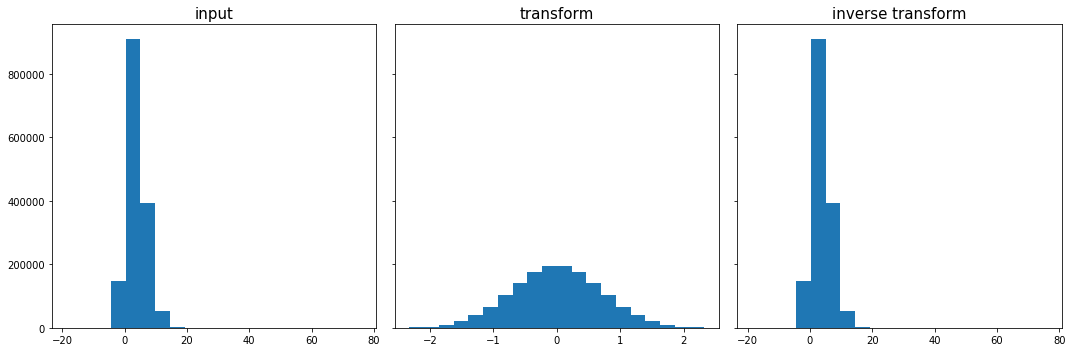

In [10]:
n_bins = 20
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].hist(x_cpu, bins=n_bins)
axs[0].set_title('input',fontsize=15)
axs[1].hist(res_cpu, bins=n_bins)
axs[1].set_title('transform',fontsize=15)
_ = axs[2].hist(x_inv_cpu, bins=n_bins)
axs[2].set_title('inverse transform',fontsize=15)
print('GaussRank CPU')

GaussRank GPU


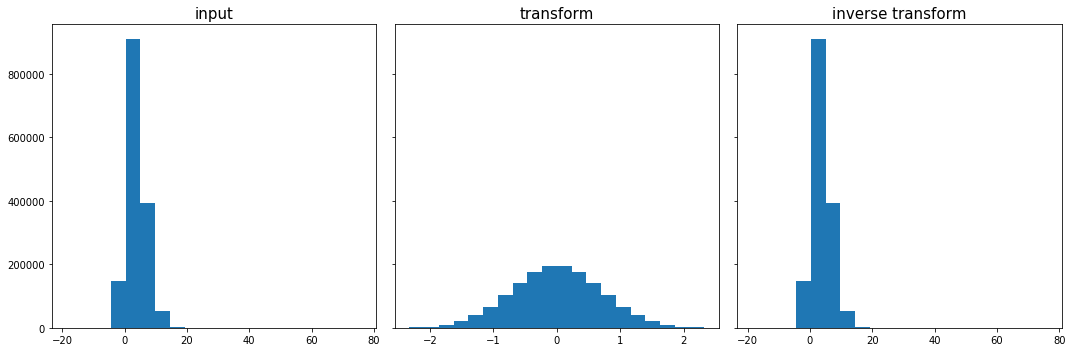

In [11]:
n_bins = 20
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].hist(cp.asnumpy(x_gpu), bins=n_bins)
axs[0].set_title('input',fontsize=15)
axs[1].hist(cp.asnumpy(res_gpu), bins=n_bins)
axs[1].set_title('transform',fontsize=15)
_ = axs[2].hist(cp.asnumpy(x_inv_gpu), bins=n_bins)
axs[2].set_title('inverse transform',fontsize=15)
print('GaussRank GPU')

### Measure the speedup with varied data size

In [12]:
cpu_time = []
gpu_time = []
for i in range(5,9):
    size = 10**i
    x = np.random.rand(size)
    
    start = time.time()
    gau_cpu = GaussRank()
    gau_cpu.fit_transform(x)
    res_cpu = gau_cpu.transform(x)
    x_inv_cpu = gau_cpu.inverse_transform(res_cpu)
    cpu_time.append(time.time()-start)
    
    start = time.time()
    x_gpu = cp.asarray(x) # don't time the conversion?
    gau_gpu = GaussRank()
    gau_gpu.fit_transform(x_gpu)
    res_gpu = gau_gpu.transform(x_gpu)
    x_inv_gpu = gau_gpu.inverse_transform(res_gpu)
    gpu_time.append(time.time()-start)

Text(0.5, 1.0, 'GaussRank: gpu vs cpu')

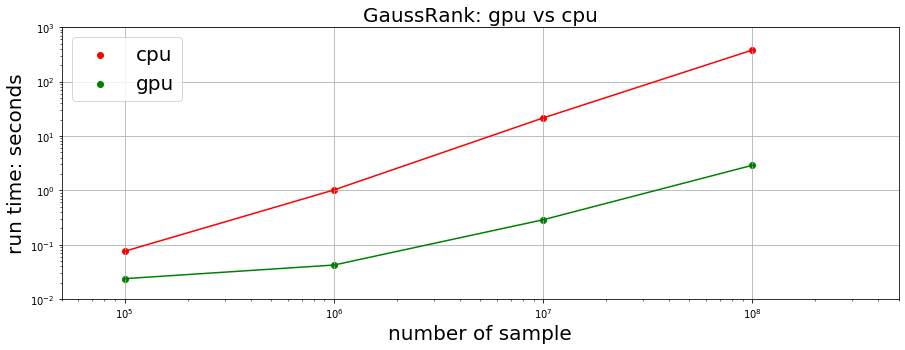

In [13]:
plt.figure(figsize=(15,5))
xs = [10**i for i in range(5,9)]
plt.yscale('log')
plt.xlim(5*10**4,5*10**8)
plt.ylim(10**(-2),10**3)
plt.xscale('log')
plt.xlabel('number of sample', fontsize=20)
plt.ylabel('run time: seconds', fontsize=20)
plt.grid()

plt.scatter(xs,cpu_time,c='r',label='cpu')  
plt.scatter(xs,gpu_time,c='g',label='gpu') 

plt.plot(xs,cpu_time,c='r')  
plt.plot(xs,gpu_time,c='g') 
plt.legend(loc='upper left', fontsize=20)
plt.title('GaussRank: gpu vs cpu', fontsize=20)

In [14]:
print(cpu_time)
print(gpu_time)

[0.07555770874023438, 1.0140976905822754, 21.42363214492798, 380.39069151878357]
[0.023673534393310547, 0.04214334487915039, 0.28704285621643066, 2.8849456310272217]


### GPU version can achieve up to 100x speedup